## Data Description

Column | Description
:---|:---
`id` | The unique ID assigned to every hotel.
`region` | The region in which the hotel is located..
`latitude` | The latitude of the hotel.
`longitude` | The longitude of the hotel.
`accommodation_type` | The type of accommodation offered by the hotel. For example: Private room, Entire house/apt, etc.
`cost` | The cost of booking the hotel for one night. (in \$\$)
`minimum_nights` | The minimum number of nights stay required.
`number_of_reviews` | The number of reviews accumulated by the hotel.
`reviews_per_month` | The average number of reviews received by the hotel per month.
`owner_id` | The unique ID assigned to every owner. An owner can own multiple hotels.
`owned_hotels` | The number of hotels owned by the owner.
`yearly_availability` | It indicates if the hotel accepts bookings around the year. Values are 0 (not available for 365 days in a year) and 1 (available for 365 days in a year).

## Load library

In [80]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import shap
pd.set_option("display.max_columns", 101)

## Load data

### Train data

In [59]:
df_train = pd.read_csv("train.csv")
print(df_train.shape)
df_train.head()

(2870, 12)


,id,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability
0,13232,Manhattan,40.71854,-74.00439,Entire home/apt,170,5,7,0.56,929983,1,0
1,246,Brooklyn,40.64446,-73.95030,Entire home/apt,65,3,238,2.30,281764,1,0
2,19091,Queens,40.78573,-73.81062,Private room,85,1,0,NaN,19923341,1,1
3,34305,Manhattan,40.73863,-73.98002,Private room,210,30,0,NaN,200380610,65,1
4,444,Manhattan,40.82426,-73.94630,Shared room,75,3,38,0.42,745069,3,1


### Test data

In [60]:
df_test = pd.read_csv("test.csv")
print(df_test.shape)
df_test.head()

(718, 11)


,id,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels
0,19215,Brooklyn,40.70912,-73.94513,Shared room,135,2,22,0.66,4360212,1
1,36301,Brooklyn,40.57646,-73.96641,Entire home/apt,69,2,8,0.90,181356989,2
2,40566,Manhattan,40.76616,-73.98228,Private room,225,30,0,NaN,13773574,12
3,33694,Manhattan,40.77668,-73.94587,Shared room,125,30,9,0.82,6788748,1
4,28873,Manhattan,40.80279,-73.94450,Entire home/apt,43,1,13,0.72,105061915,2


## Exploratory Data Analysis (EDA)

##### Insight

According to quick review for the train and test datasets, "review_per_month" column contains missing values in the both datasets. Thus, we need to impute the missing values in the "review_per_month" column in the latter step.

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2870 entries, 0 to 2869
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   2870 non-null   int64  
 1   region               2870 non-null   object 
 2   latitude             2870 non-null   float64
 3   longitude            2870 non-null   float64
 4   accommodation_type   2870 non-null   object 
 5   cost                 2870 non-null   int64  
 6   minimum_nights       2870 non-null   int64  
 7   number_of_reviews    2870 non-null   int64  
 8   reviews_per_month    2194 non-null   float64
 9   owner_id             2870 non-null   int64  
 10  owned_hotels         2870 non-null   int64  
 11  yearly_availability  2870 non-null   int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 269.2+ KB


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  718 non-null    int64  
 1   region              718 non-null    object 
 2   latitude            718 non-null    float64
 3   longitude           718 non-null    float64
 4   accommodation_type  718 non-null    object 
 5   cost                718 non-null    int64  
 6   minimum_nights      718 non-null    int64  
 7   number_of_reviews   718 non-null    int64  
 8   reviews_per_month   545 non-null    float64
 9   owner_id            718 non-null    int64  
 10  owned_hotels        718 non-null    int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 61.8+ KB


In [15]:
#
# Create two distinct lists to store categorical and numerical columns seperatly
# yearly_availability column's data type is int64 but I assumed it as categorical variable because of its binary distribution
#

features_cat = df_train.select_dtypes(include=['object']).columns.to_list()
features_cat.extend(['yearly_availability']) 
print(features_cat)

features_num = df_train.select_dtypes(include=['int64']).columns.to_list()
features_num.extend(df_train.select_dtypes(include=['float64']).columns.to_list())
features_num = [col for col in features_num if col not in ['id', 'yearly_availability']]
print(features_num)

['region', 'accommodation_type', 'yearly_availability']
['cost', 'minimum_nights', 'number_of_reviews', 'owner_id', 'owned_hotels', 'latitude', 'longitude', 'reviews_per_month']


### Categorical features

##### Insight

For the region column, all hotels in the data are located in New York City. Of several sub-areas in the New York City, Manhatten and Brooklyn areas have higher number of hotels. Regarding to the accommodation type column, private room is the most common type. According to the yearly availability column, the data looks well balanced to train a model.

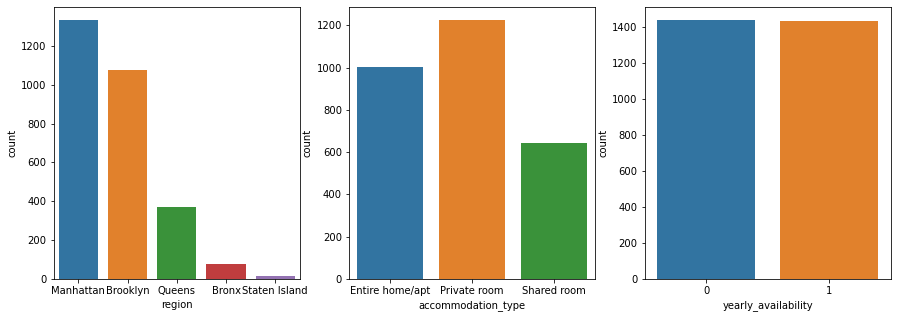

In [17]:
plt.figure(figsize=(15,5))
for idx, cat in enumerate(features_cat):
    plt.subplot(1,3,idx+1)
    sns.countplot(data=df_train, x=cat)
plt.show()

### Numerical features

##### Insight

In a case of the minimum nights column, there might be some errorneous inputs. For example, 29 or 30 days as minimum nights for hotels does not make sense. It may be necessary to scrutanize the column to see whether there are errors and abnomalies. Across these numberical columns, abnomaly detection is required.

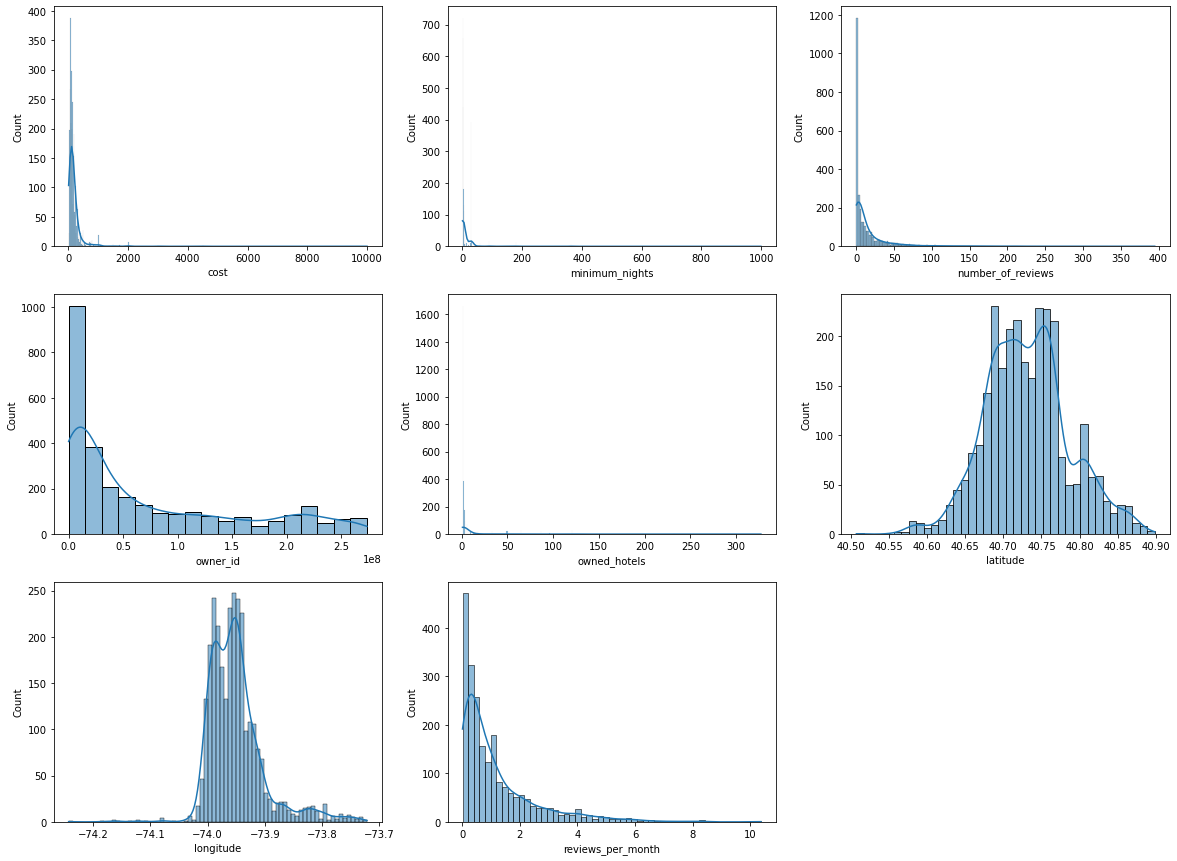

In [23]:
plt.figure(figsize=(20,15))
for idx, num in enumerate(features_num):
    plt.subplot(3,3,idx+1)
    sns.histplot(df_train[num], kde=True)
plt.show()

#### Reviews_per_month with missing value

##### Insight

I found the reason why the "reviews_per_month" column has missing values. It is because the hotels having missing values in the "reviews_per_month" column do not have reviews in "number_of_review" column. Thus, without using a fancy techniue for the imputation, it would be enough to replace null value with zero.

In [32]:
print('Number of rows whose reviews_per_month is null: {}'.format(df_train.loc[df_train['reviews_per_month'].isnull()==True].shape[0]))
print('Number of rows whose number_of_reviews is zero: {}'.format(df_train.loc[df_train['number_of_reviews']==0].shape[0]))
print('Number of rows whose both reviews_per_month and number_of_reviews are null or zero: {}'.format(df_train.loc[df_train['reviews_per_month'].isnull()==True, 'number_of_reviews'].shape[0]))

Number of rows whose reviews_per_month is null: 676
Number of rows whose number_of_reviews is zero: 676
Number of rows whose both reviews_per_month and number_of_reviews are null or zero: 676


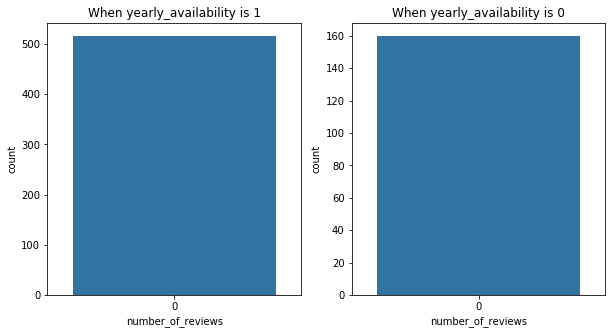

In [235]:
plt.figure(figsize=(10,5))
for idx, target in enumerate([1,0]):
    plt.subplot(1,2,idx+1)
    sns.countplot(data=df_train.loc[(df_train['reviews_per_month'].isnull()==True) & (df_train['yearly_availability']==target)], x='number_of_reviews').set(title='When yearly_availability is {}'.format(target))
plt.show()

## Feature Engineering

### Impute missing values

In [61]:
df_train.loc[(df_train['reviews_per_month'].isnull()==True), 'reviews_per_month'] = 0.0

### Drop columns

After review the feature importance below, columns related to identifiers have weak impact on the decition. Therefore, I dropped these columns. Commonly in data science task, it can be assumeed that these features would not impact on the prediction.

In [63]:
df_train.drop(['id', 'owner_id'], axis=1, inplace=True)
df_test.drop(['id', 'owner_id'], axis=1, inplace=True)

### One-Hot Encoding

In [64]:
df_train= pd.get_dummies(df_train, columns=[col for col in features_cat if col not in ['yearly_availability']]).copy()
df_train.head()

,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owned_hotels,yearly_availability,region_Bronx,region_Brooklyn,region_Manhattan,region_Queens,region_Staten Island,accommodation_type_Entire home/apt,accommodation_type_Private room,accommodation_type_Shared room
0,40.71854,-74.00439,170,5,7,0.56,1,0,0,0,1,0,0,1,0,0
1,40.64446,-73.95030,65,3,238,2.30,1,0,0,1,0,0,0,1,0,0
2,40.78573,-73.81062,85,1,0,0.00,1,1,0,0,0,1,0,0,1,0
3,40.73863,-73.98002,210,30,0,0.00,65,1,0,0,1,0,0,0,1,0
4,40.82426,-73.94630,75,3,38,0.42,3,1,0,0,1,0,0,0,0,1


In [65]:
df_test= pd.get_dummies(df_test, columns=[col for col in features_cat if col not in ['yearly_availability']]).copy()
df_test.head()

,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owned_hotels,region_Bronx,region_Brooklyn,region_Manhattan,region_Queens,region_Staten Island,accommodation_type_Entire home/apt,accommodation_type_Private room,accommodation_type_Shared room
0,40.70912,-73.94513,135,2,22,0.66,1,0,1,0,0,0,0,0,1
1,40.57646,-73.96641,69,2,8,0.90,2,0,1,0,0,0,1,0,0
2,40.76616,-73.98228,225,30,0,NaN,12,0,0,1,0,0,0,1,0
3,40.77668,-73.94587,125,30,9,0.82,1,0,0,1,0,0,0,0,1
4,40.80279,-73.94450,43,1,13,0.72,2,0,0,1,0,0,1,0,0


## Build model

### Split data

In [66]:
X = df_train.drop(['yearly_availability'], axis=1)
y = df_train['yearly_availability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Train model (Base) 

XGBoost is the most powerful algorithm in machine learning domain.

In [83]:
xgb_cl = xgb.XGBClassifier(
    eval_metric='auc',
    use_label_encoder=False
)

xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Test model (Base)

Accuracy score: 0.92
ROC AUC on prediction: 0.9162414965986394



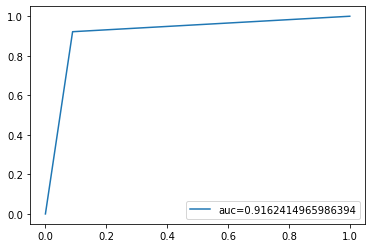

In [84]:
y_pred = xgb_cl.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy score: {:.2f}'.format(accuracy))

print("ROC AUC on prediction: {}\n".format(roc_auc_score(y_test, y_pred)))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Feature importance


##### Insight

According to the feature importance by SHAP values, private room in "accommodation_type" column and "owned_hotels" columns have huge impacts on the decision than other columns. On the other hand, region types have a few impacts on the decision.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


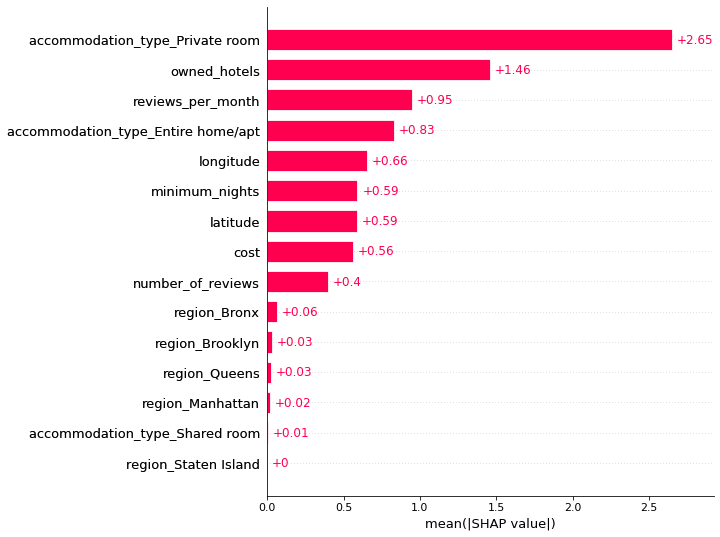

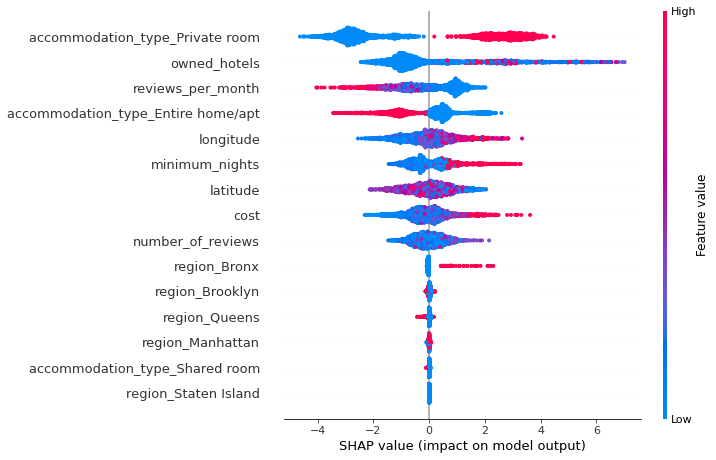

In [69]:
explainer = shap.Explainer(xgb_cl)
shap_values = explainer(X_train)

shap.plots.bar(shap_values, max_display=20)
shap.summary_plot(shap_values, X_train)

Text(0.5, 0, 'Xgboost Feature Importance')

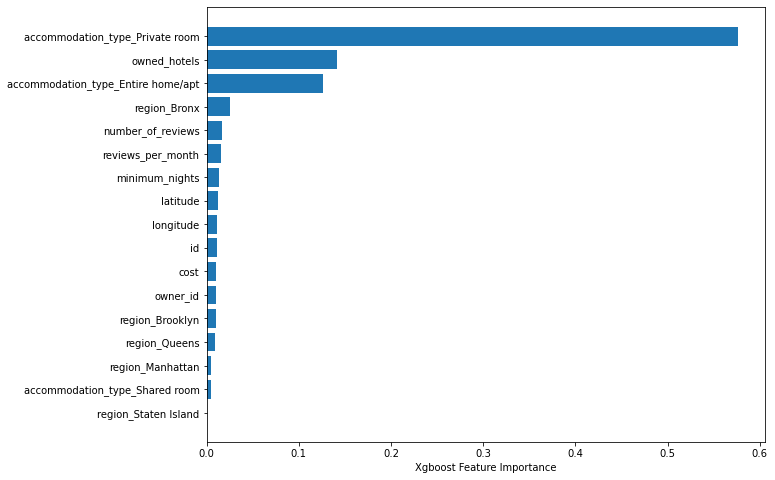

In [43]:
idx_sorted = xgb_cl.feature_importances_.argsort()
plt.figure(figsize=(10,8))
plt.barh(X.columns[idx_sorted], xgb_cl.feature_importances_[idx_sorted])
plt.xlabel("Xgboost Feature Importance")

### Tune hyperparameters (Bayesian Optimization)

The bayesian optimization method generally works better than GridSearch and RandomizedSearch in terms of time consuming and efficiency.

In [85]:
pbounds = {
    'learning_rate': (.01, .2),
    'max_depth': (3, 10),
    'min_child_weight':(0, 10),
    'subsample':(.5, 1),
    'colsample_bytree':(.5, 1)
}

def cv_xgb(learning_rate, max_depth, min_child_weight, subsample, colsample_bytree):
    params = {
        'learning_rate':learning_rate,
        'max_depth':int(round(max_depth)),
        'min_child_weight':min_child_weight,
        'subsample':subsample,
        'colsample_bytree':colsample_bytree
    }

    model = xgb.XGBClassifier(
        **params,
        eval_metric='auc',
        use_label_encoder=False
    )
    
    #score_accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))
    
    

bo = BayesianOptimization(f=cv_xgb, pbounds=pbounds, random_state=42)
bo.maximize(init_points=10, n_iter=100)
#bo.maximize(init_points=5, n_iter=10)
#bo.maximize(init_points=5, n_iter=20, acq='ei', xi=0.01)
bo.max

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.922    |  0.6873   |  0.1906   |  8.124    |  5.987    |  0.578    |
|  2        |  0.9255   |  0.578    |  0.02104  |  9.063    |  6.011    |  0.854    |
|  3        |  0.9203   |  0.5103   |  0.1943   |  8.827    |  2.123    |  0.5909   |
|  4        |  0.9238   |  0.5917   |  0.06781  |  6.673    |  4.319    |  0.6456   |
|  5        |  0.9255   |  0.8059   |  0.0365   |  5.045    |  3.664    |  0.728    |
|  6        |  0.9247   |  0.8926   |  0.04794  |  6.6      |  5.924    |  0.5232   |
|  7        |  0.9255   |  0.8038   |  0.0424   |  3.455    |  9.489    |  0.9828   |
|  8        |  0.9229   |  0.9042   |  0.06788  |  3.684    |  6.842    |  0.7201   |
|  9        |  0.9247   |  0.561    |  0.1041   |  3.241    |  9.093    |  0.6294   |
|  10       |  0.9238   |  0.8313   |  0.06923  |  6.6

|  58       |  0.9255   |  0.986    |  0.1005   |  9.8      |  4.429    |  0.7491   |
|  59       |  0.9255   |  0.7828   |  0.05542  |  3.753    |  8.463    |  0.9775   |
|  60       |  0.9268   |  0.5354   |  0.1535   |  6.046    |  3.658    |  0.9563   |
|  61       |  0.922    |  0.6989   |  0.1731   |  9.69     |  7.11     |  0.7979   |
|  62       |  0.922    |  0.8673   |  0.05932  |  8.829    |  8.58     |  0.8167   |
|  63       |  0.9225   |  0.8388   |  0.1268   |  8.819    |  8.676    |  0.9898   |
|  64       |  0.9233   |  0.5944   |  0.1798   |  7.632    |  5.145    |  0.8637   |
|  65       |  0.9242   |  0.7757   |  0.1316   |  6.085    |  4.059    |  0.8752   |
|  66       |  0.9242   |  0.7722   |  0.1062   |  7.992    |  4.758    |  0.9586   |
|  67       |  0.9273   |  0.9215   |  0.06367  |  4.026    |  2.017    |  0.5298   |
|  68       |  0.9277   |  0.7459   |  0.02581  |  4.997    |  9.571    |  0.8759   |
|  69       |  0.9255   |  0.6632   |  0.01108  |  4.2

{'target': 0.930317324997632,
 'params': {'colsample_bytree': 0.7389695845124129,
  'learning_rate': 0.023401351198680576,
  'max_depth': 8.25347712514009,
  'min_child_weight': 0.8491036978229816,
  'subsample': 0.953677125752442}}

### Train model (Optimized)

In [86]:
xgb_cl = xgb.XGBClassifier(
    colsample_bytree=bo.max['params']['colsample_bytree'],
    learning_rate=bo.max['params']['learning_rate'],
    max_depth=int(bo.max['params']['max_depth']),
    min_child_weight=bo.max['params']['min_child_weight'],
    subsample=bo.max['params']['subsample'],
    eval_metric='auc',
    use_label_encoder=False
)

xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7389695845124129,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.023401351198680576, max_delta_step=0, max_depth=8,
              min_child_weight=0.8491036978229816, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.953677125752442, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

### Test model (Optimized)

Accuracy score: 0.92
ROC AUC on prediction: 0.9175170068027212



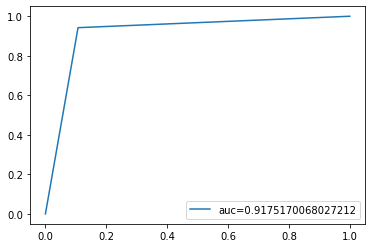

In [87]:
y_pred = xgb_cl.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy score: {:.2f}'.format(accuracy))

print("ROC AUC on prediction: {}\n".format(roc_auc_score(y_test, y_pred)))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label="auc="+str(auc))
plt.legend(loc=4)
plt.show()